In [246]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

In [247]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


In [248]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long).to(device)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)].to(device)
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1]).to(device)
    return (max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))).to(device)

In [249]:
from torchtext.vocab import Vectors
glove_path = 'glove.6B.50d.txt'
glove = Vectors(name=glove_path)

In [250]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, tag_to_ix, embedding_dim, hidden_dim, pretrained_embedding_matrix):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        
        # embedding_matrix = glove.get_vecs_by_tokens(list(word_to_ix.keys()))

        # embedding_matrix = glove.get_vecs_by_tokens(word_to_ix.keys())
        self.word_embeds = nn.Embedding.from_pretrained(pretrained_embedding_matrix).to(device)
        
        

        # self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True).to(device)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size).to(device)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size)).to(device)

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas
        forward_var = forward_var.to(device)

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                emit_score = emit_score.to(device)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                trans_score = trans_score.to(device)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags.to(device)]).to(device)
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]].to(device)
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]].to(device)
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars.to(device)
        
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag].to(device)
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1).to(device)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]].to(device)
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence).to(device)
        forward_score = self._forward_alg(feats).to(device)
        gold_score = self._score_sentence(feats, tags).to(device)
        return (forward_score - gold_score).to(device)

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [251]:
import pandas as pd  

with open('train.txt') as f:
    contents = f.read()
    data = contents.split('\n\n')
     
result = []

for block in data:
    lines = block.strip().split('\n')
    if len(lines[0]) == 0: 
        break
    words, tags = zip(*[line.split('\t') for line in lines])
    result.append((list(words), list(tags)))

training_data = result

word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)


tag_to_ix = {"O": 0, "B-geo-loc": 1, "B-facility": 2, "I-facility": 3, "B-movie": 4, 
             "I-movie": 5, "B-company": 6, "B-product": 7, "B-person": 8, "B-sportsteam": 9,
             "I-sportsteam": 10, "I-product": 11, "B-other": 12, "I-other": 13, "I-company": 14,
             "I-person": 15, "I-geo-loc": 16, "B-tvshow": 17, "B-musicartist": 18, "I-musicartist": 19,
             "I-tvshow": 20, START_TAG: 21, STOP_TAG: 22}

ix_to_tag = {v: k for k, v in tag_to_ix.items()}

(tensor(30.1515, device='cuda:0'), [9, 11, 9, 11, 9, 11, 9, 11, 9, 11, 9, 11])


Epoch 0: 100%|██████████| 2394/2394 [07:56<00:00,  5.02it/s]


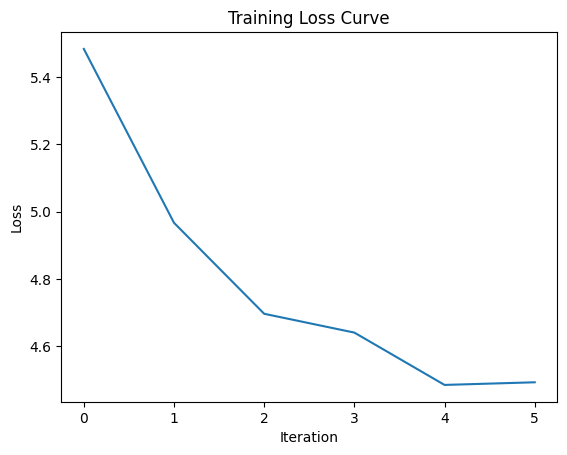

In [256]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 50
HIDDEN_DIM = 4
batch_size = 32
num_epochs = 1


pretrained_embedding_matrix = glove.vectors

model = BiLSTM_CRF(tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, pretrained_embedding_matrix)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

from tqdm import tqdm

# Check predictions before training
output = []
with torch.no_grad():
    precheck_sent = []
    for word in training_data[0][0]:
        if word in glove.stoi:
            # 如果单词在 GloVe 中，使用 GloVe 的索引
            word_vector = glove.stoi[word]
        else:
            # 如果单词不在 GloVe 中，检查是否在 word_to_ix 中，如果不在，添加它
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)  
            # 使用 word_to_ix 中的索引
            word_vector = word_to_ix[word]

        precheck_sent.append(word_vector)

    # 将列表转换为张量
    precheck_sent = torch.tensor(precheck_sent, dtype=torch.long).to(device)

    # precheck_sent = prepare_sequence(training_data[0][0], word_to_ix).to(device)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long).to(device)
    print(model(precheck_sent))

import matplotlib.pyplot as plt
smoothing_window = 100

losses = []  # 保存每个iteration的损失值
average_losses = []  # 保存滑动平均后的损失值

# 定义保存模型的文件名和路径
model_checkpoint_path = "model_checkpoint.pth"

import os

# 创建模型和优化器
model = BiLSTM_CRF(tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, pretrained_embedding_matrix).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# 检查是否有以前保存的检查点文件
if os.path.isfile(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path)
    # 加载模型和优化器状态
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
    average_losses = checkpoint['average_losses']
else:
    start_epoch = 0


# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0  
    for sentence, tags in tqdm(training_data, desc=f"Epoch {epoch}"):
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_indices = []
        for word in sentence:
            if word in glove.stoi:
                index = glove.stoi[word]
            elif word in word_to_ix:
                index = word_to_ix[word]
            else:
                # If the word is not in GloVe or word_to_ix, you can assign a special index or handle it as needed
                # Here, we'll assign a special index for unknown words.
                index = word_to_ix["<UNKNOWN>"]
            sentence_indices.append(index)

        sentence_in = torch.tensor(sentence_indices, dtype=torch.long).to(device)

        # sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets).to(device)
        
        losses.append(loss.item())
        total_loss += loss.item()

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()
    
    if len(losses) >= smoothing_window:
        average_loss = sum(losses[-smoothing_window:]) / smoothing_window
        average_losses.append(average_loss)
    else:
        average_losses.append(average_loss)    
        
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'average_losses': average_losses
    }
    torch.save(checkpoint, model_checkpoint_path)
    
plt.plot(average_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# We got it!

In [266]:
output = []
pred = []
with torch.no_grad():
    for i in range(len(training_data)):
        precheck_sent = []
        for word in training_data[i][0]:
            if word in glove.stoi:
                # 如果单词在 GloVe 中，使用 GloVe 的索引
                word_vector = glove.stoi[word]
                
                # print(word, word_vector)
            else:
                # 如果单词不在 GloVe 中，检查是否在 word_to_ix 中，如果不在，添加它
                if word not in word_to_ix:
                    word_to_ix[word] = len(word_to_ix)
                    
                    # print(word, word_to_ix[word])
                # 使用 word_to_ix 中的索引
                word_vector = word_to_ix[word]
            # print(training_data[i])
            precheck_sent.append(word_vector)
            print(precheck_sent)

        # 将列表转换为张量
        precheck_sent = torch.tensor(precheck_sent, dtype=torch.long).to(device)
        output = [ix_to_tag[p] for p in model(precheck_sent)[1]]
        pred.append(output)

[0]
[0, 1]
[0, 1, 39]
[0, 1, 39, 43]
[0, 1, 39, 43, 30]
[0, 1, 39, 43, 30, 64]
[0, 1, 39, 43, 30, 64, 751]
[0, 1, 39, 43, 30, 64, 751, 21]
[0, 1, 39, 43, 30, 64, 751, 21, 8]
[0, 1, 39, 43, 30, 64, 751, 21, 8, 1853]
[0, 1, 39, 43, 30, 64, 751, 21, 8, 1853, 285]
[0, 1, 39, 43, 30, 64, 751, 21, 8, 1853, 285, 11]
[12]
[12, 20]
[12, 20, 137]
[12, 20, 137, 163]
[12, 20, 137, 163, 4]
[12, 20, 137, 163, 4, 17]
[12, 20, 137, 163, 4, 17, 2]
[12, 20, 137, 163, 4, 17, 2, 19]
[12, 20, 137, 163, 4, 17, 2, 19, 38236]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30, 22]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30, 22, 23]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30, 22, 23, 85]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30, 22, 23, 85, 1]
[12, 20, 137, 163, 4, 17, 2, 19, 38236, 36, 4, 30, 22, 23, 85, 1, 34]
[12, 20, 137, 163, 4, 17, 2, 19, 3823

In [267]:
ans = []
count = 0
for data in training_data:
    # if count < 100:
        ans.append(data[1])
        count+=1
len(ans)

2394

In [268]:
len(pred)

2394

In [271]:
for i in range(10):
    print(ans[i])
    print(pred[i])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B-geo-loc', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-facility', 'I-facility', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-facility', 'I-facility', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-movie', 'I-movie', 'O', 'O', 'O', 'B-geo-loc', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [272]:
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

y_true = ans
y_pred = pred
print(accuracy_score(y_true, y_pred))
from seqeval.scheme import IOB2
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

0.946953883233984
              precision    recall  f1-score   support

     company       0.00      0.00      0.00       171
    facility       0.00      0.00      0.00       104
     geo-loc       0.00      0.00      0.00       276
       movie       0.00      0.00      0.00        34
 musicartist       0.00      0.00      0.00        55
       other       0.00      0.00      0.00       225
      person       0.00      0.00      0.00       449
     product       0.00      0.00      0.00        97
  sportsteam       0.00      0.00      0.00        51
      tvshow       0.00      0.00      0.00        34

   micro avg       0.00      0.00      0.00      1496
   macro avg       0.00      0.00      0.00      1496
weighted avg       0.00      0.00      0.00      1496



In [279]:
with open('test-submit.txt') as f:
    contents = f.read()
    data = contents.split('\n\n')
     
submit = []

for block in data:
    lines = block.strip().split('\n')
    if len(lines[0]) == 0: 
        break
    submit.append(lines)


In [281]:
output = []
pred = []
with torch.no_grad():
    for i in range(len(submit)):
        precheck_sent = []
        for word in submit[i]:
            if word in glove.stoi:
                # 如果单词在 GloVe 中，使用 GloVe 的索引
                word_vector = glove.stoi[word]
                
                # print(word, word_vector)
            else:
                # 如果单词不在 GloVe 中，检查是否在 word_to_ix 中，如果不在，添加它
                if word not in word_to_ix:
                    word_to_ix[word] = len(word_to_ix)
                    
                    # print(word, word_to_ix[word])
                # 使用 word_to_ix 中的索引
                word_vector = word_to_ix[word]
            # print(training_data[i])
            precheck_sent.append(word_vector)
            # print(precheck_sent)

        # 将列表转换为张量
        precheck_sent = torch.tensor(precheck_sent, dtype=torch.long).to(device)
        output = [ix_to_tag[p] for p in model(precheck_sent)[1]]
        pred.append(output)  
pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  '

In [288]:
with open('submit.txt', 'w') as file:
    for words, tags in zip(submit, pred):
        for word, tag in zip(words, tags):
            file.write(f"{word}\t{tag}\n")
        file.write('\n')  # 添加一个空行表示不同的句子
